## Coursera Machine Learning for Data Analysis
### Week 4 Assignment - K-means Clustering

#### Intro
I decided to work with a famous dataset - the [Pima Indians Diabetes Database](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names), which gives you different parameters regarding Indian women's health and medical history, along with a label of having or not having diabetes.<br>
We'll try to run the K-means clustering procedure on the data to see if we can find clusters of similar observations, explore what the right value of K is, and try to interpert and evaluate our work.<br>


In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report  # ??
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.metrics
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default') # Makes the charts a little prettier
%matplotlib inline

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


### Getting and preparing the data

In [2]:
# Pima Indian Diabetes dataset from the UCI Machine Learning Repository

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

print pima.shape

pima.head()

(768, 9)


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Here is the codebook for the labels, by order of appearance - left to right:<br>
(copied directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names))
1. Number of times pregnant
+ Plasma glucose concentration a 2 hours in an oral glucose tolerance test
+ Diastolic blood pressure (mm Hg)
+ Triceps skin fold thickness (mm)
+ 2-Hour serum insulin (mu U/ml)
+ Body mass index (weight in kg/(height in m)^2)
+ Diabetes pedigree function
+ Age (years)
+ Class variable (0 or 1)


In [3]:
# let's verify there are no missing values we need to handle

pima.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnant    768 non-null int64
glucose     768 non-null int64
bp          768 non-null int64
skin        768 non-null int64
insulin     768 non-null int64
bmi         768 non-null float64
pedigree    768 non-null float64
age         768 non-null int64
label       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Prepare the data
X = pima.copy().drop('label', axis=1)
X.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [5]:
# Scale the data

for col in X.columns:
    X[col] = preprocessing.scale(X[col].astype('float64'))
    
X.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


In [6]:
x_cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']

In [7]:
# This will be useful later on:
X_copy = X.copy()

### Findings the optimal value of K

I tried the 'elbow' method to find an optimal value for K, but could not get meaningful results. Instead, we'll use the Silhouette Score method.<br>
Steps:<br>
We'll fit the model for each value of K between 2 an 19 (inclusive)<br>
Calculate the SC for each K.<br>
Choose the K that yields the highest SC.

In [8]:
# calculate SC for K=2 through K=19
k_range = range(2, 20)
scores = []
for k in k_range:
    X_temp = X_copy.copy()
    km = KMeans(n_clusters=k)
    km.fit(X_temp[x_cols])
    scores.append(sklearn.metrics.silhouette_score(X_temp, km.labels_))
    del X_temp

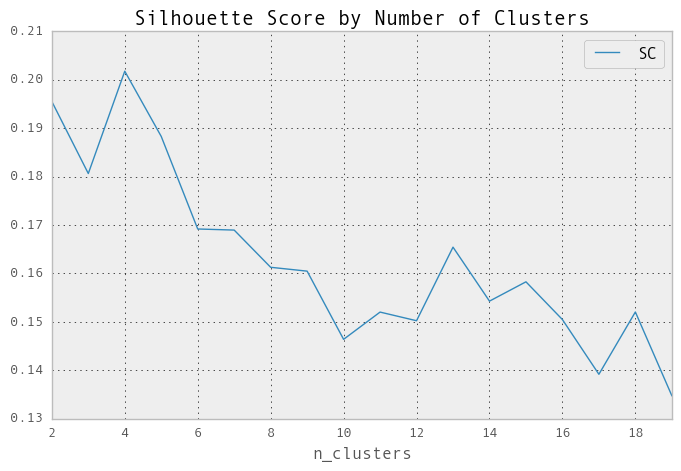

In [9]:
sc_df = pd.DataFrame({'n_clusters': k_range, 'SC': scores}).set_index('n_clusters')
sc_df.plot(title='Silhouette Score by Number of Clusters', figsize=(8, 5))

**RESULT**: We see that **K=4** yields the highest SC, of approx. 0.2. Notice that SC is between -1 to 1, so 0.2 is OK, but not great. Still, this is the best value we get, and we'll continue with it.

### Explore and analyze K-Means when K=4

Notice that we don't split to training set and testing set since the number of observations is a-priori relatively small, as was suggested in the course.

In [10]:
km = KMeans(n_clusters=4)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
# Add a 'cluster' value per row
X['cluster'] = km.labels_

X['cluster'].value_counts()

2    344
1    212
0    176
3     36
Name: cluster, dtype: int64

In [12]:
X.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,cluster
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,2
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,2
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,0


In [13]:
X['label'] = pima['label']

In [14]:
# Let's use principle component analysis to be able to plot the clusters on a 2D chart

pca = PCA(n_components=2)
X['x'] = pca.fit_transform(X[x_cols])[:,0]
X['y'] = pca.fit_transform(X[x_cols])[:,1]
matrix = X.reset_index()

customer_clusters = X[['label', 'cluster', 'x', 'y']]
customer_clusters.head()

,label,cluster,x,y
0,1,1,-1.068503,1.234895
1,0,2,1.121683,-0.733852
2,1,1,0.396477,1.595876
3,0,2,1.115781,-1.271241
4,1,0,-2.359334,-2.184819


/Applications/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:968: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


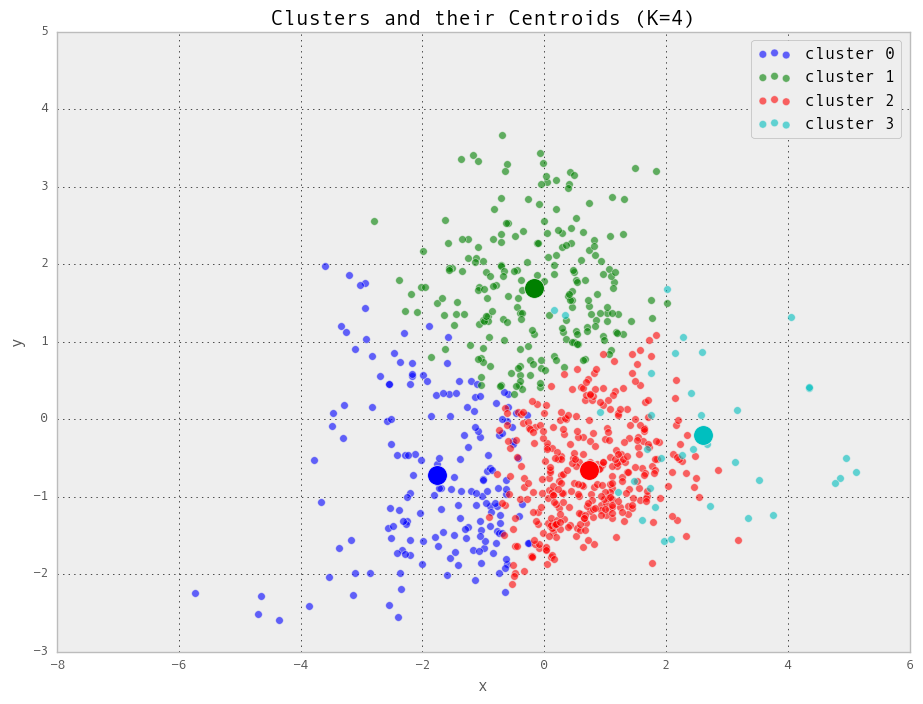

In [15]:
# Let's plot the clusters with their centroids

cluster_centers = pca.transform(km.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
cluster_centers['color'] = colors[:cluster_centers.shape[0]]

ax = X[X['cluster']==0].plot.scatter('x', 'y', figsize=(11, 8), colors=colors[0], alpha=0.6, label='cluster 0', s=30)

for i in range(1, max(X['cluster']+1)):
    X[X['cluster']==i].plot.scatter('x', 'y', colors=colors[i], label='cluster '+str(i), ax=ax, alpha=0.6, s=30)

for i in range(0, max(X['cluster']+1)):
    cluster_centers[cluster_centers['cluster']==i].plot.scatter('x', 'y', colors=colors[i], ax=ax, s=200)
    
ax.set_title('Clusters and their Centroids (K=4)', fontsize=15)

In [16]:
# Some descriptive statistics
X.groupby('cluster').mean()[x_cols]

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
cluster,,,,,,,,
0,-0.227330,0.818627,0.273598,0.921883,1.159428,0.714719,0.538143,-0.058689
1,1.030766,0.252940,0.451536,-0.475410,-0.450671,-0.006601,-0.111428,1.085243
2,-0.509935,-0.561958,-0.047983,-0.056992,-0.243576,-0.278871,-0.181782,-0.613885
3,-0.085971,-0.121888,-3.538132,-1.162756,-0.686861,-0.790541,-0.237712,-0.237943


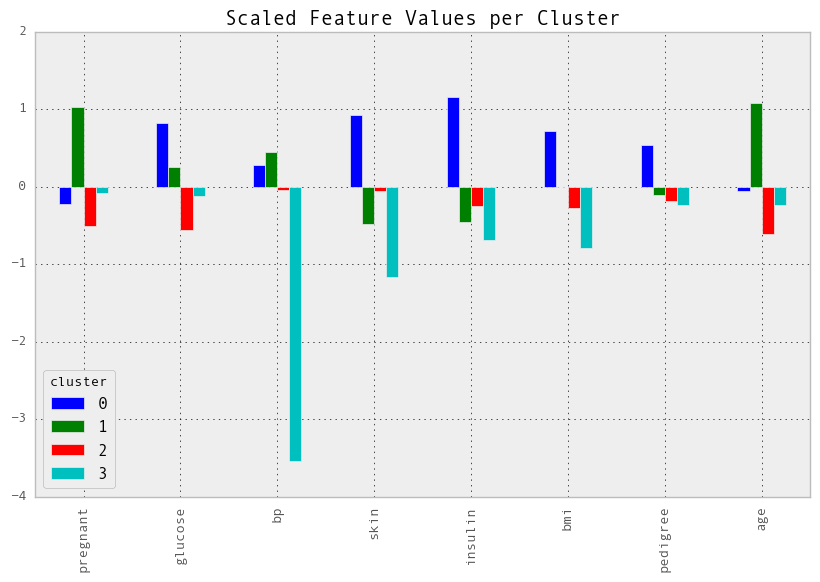

In [17]:
X.groupby('cluster').mean()[x_cols].T.plot(kind='bar', figsize=(10,6), 
                                   title='Scaled Feature Values per Cluster', colors=['b', 'g', 'r', 'c'])

**RESULT**: We can see in the top chart that clusters 0, 1, 2 are pretty distinct and separated from one another, but there is some overlap between clusters 2 and 3 (red and cyan). We can see in the bottom chart that for almost all features the values of the two clusters are very far off from one another (excep for pedigree), so the disinction to two separate clusters seems to make sense.

Now, let's return to the original labelled data, apply the clusters we found, and see if we can find anything interesting about the features!

In [18]:
pima['cluster'] = km.labels_

In [19]:
pd.DataFrame(pima.groupby('cluster')['label'].mean())

,label
cluster,
0,0.602273
1,0.481132
2,0.127907
3,0.444444


**RESULT**: We can see that in cluster 0 diabetes is almost 5x more common than in cluster 2! <br>
Let's take a closer look at the feature values:

In [20]:
pima.groupby('cluster')[x_cols].mean().round(2)

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
cluster,,,,,,,,
0,3.08,147.05,74.40,35.23,213.33,37.62,0.65,32.55
1,7.32,128.98,77.84,12.96,27.90,31.94,0.43,46.00
2,2.13,102.94,68.18,19.63,51.75,29.80,0.41,26.03
3,3.56,117.00,0.67,2.00,0.69,25.76,0.39,30.44


In [23]:
# And compare Cluster 3 to Cluster 1:

pima.groupby('cluster')[x_cols].mean().round(2).loc[0, :].div(
    pima.groupby('cluster')[x_cols].mean().round(2).loc[2, :], axis='index')

pregnant    1.446009
glucose     1.428502
bp          1.091229
skin        1.794702
insulin     4.122319
bmi         1.262416
pedigree    1.585366
age         1.250480
dtype: float64

**RESULT**: We see that the values for insulin, skin, pedigree, pregnant and glucose are significantly greater for Cluster 0 where there are more diabetes patients. We should take this with a pinch of salt, because we don't know if there's a linear relationship between the levels of these features/health indicators and the probability of diabetes.

### Conclusion

We ran a K-means clustering model, and using the Silouette Score method we found the optimal value of K was 4.<br>
We then plotted the observation post PCA by clusters for K=4, and saw the clusters are indeed pretty distinct and not overlapping.<br>
Finally, we added the labels back to see if difference in feature values that separate observations to clusters also translate to difference in propensity for diabetes, and got some indication that this is indeed the case.